In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [ ]:
import zipfile

zip_file_path = "dataset/playground-series-s3e3.zip"
extracted_path = "dataset/"

with zipfile.ZipFile(zip_file_path,"r") as zip_ref:
    zip_ref.extractall(extracted_path)
    
print("Zip file Extracted")

In [3]:
df = pd.read_csv("dataset/train.csv")
test = pd.read_csv("dataset/test.csv")
df.head()

,id,Age,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EnvironmentSatisfaction,...,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,Attrition
0,0,36,Travel_Frequently,599,Research & Development,24,3,Medical,1,4,...,80,1,10,2,3,10,0,7,8,0
1,1,35,Travel_Rarely,921,Sales,8,3,Other,1,1,...,80,1,4,3,3,4,2,0,3,0
2,2,32,Travel_Rarely,718,Sales,26,3,Marketing,1,3,...,80,2,4,3,3,3,2,1,2,0
3,3,38,Travel_Rarely,1488,Research & Development,2,3,Medical,1,3,...,80,0,15,1,1,6,0,0,2,0
4,4,50,Travel_Rarely,1017,Research & Development,5,4,Medical,1,2,...,80,0,31,0,3,31,14,4,10,1


In [4]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
for col in df.columns:
    if df[col].dtype == "O":
        le.fit(df[col])
        df[col] = le.transform(df[col])
        test[col] = le.transform(test[col])

In [5]:
x_cols = [col for col in df.columns if col not in ["id","Attrition"]]
y_cols = ["Attrition"]

In [6]:
att = df[df["Attrition"] == 1]
dff = pd.concat([df,att,att,att], axis = 0)

# Shuffle the DataFrame
shuffled_df = dff.sample(frac=1.0, random_state=42)

# Reset the index if needed
shuffled_df.reset_index(drop=True, inplace=True)


In [139]:
X = df[x_cols]
y = df[y_cols]

In [8]:
Xd = shuffled_df[x_cols]
xtest = test[x_cols]
yd = shuffled_df[y_cols]

In [85]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.ensemble import AdaBoostClassifier, HistGradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

def cross_validation(X,y,estimator,n_splits, xtest=None):

    skf = StratifiedKFold(n_splits=n_splits, random_state=42, shuffle=True)

    acc_scr = []
    f1_scr = []
    auc_scr = []
    
    if xtest is not None:
        preds = np.zeros(len(xtest))
    else:
        preds = None

    for i, (train_index, test_index) in enumerate(skf.split(X, y)):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        estimator.fit(X_train,y_train)
        

        y_preds = estimator.predict(X_test)

        if xtest is not None:
            test_preds = estimator.predict_proba(xtest)[:, 1] / n_splits
            if preds is None:
                preds = test_preds
            else:
                preds += test_preds

        acc_scr.append(accuracy_score(y_test, y_preds))
        f1_scr.append(f1_score(y_test, y_preds))
        auc_scr.append(roc_auc_score(y_test, estimator.predict_proba(X_test)[:, 1]))

    avg_acc = round(np.mean(acc_scr), 4)
    avg_f1 = round(np.mean(f1_scr), 4)
    avg_roc = round(np.mean(auc_scr), 4)

    print(f"Average accuracy score of {n_splits} is : {avg_acc}")
    print(f"Average f1 score of {n_splits} is       : {avg_f1}")
    print(f"Average roc score of {n_splits} is      : {avg_roc}")

    return preds

In [12]:
import warnings
warnings.filterwarnings("ignore")

In [17]:
import xgboost as xgb
import optuna

In [264]:
def cross_validation(X,y,best_params,n_splits, xtest=None):

    skf = StratifiedKFold(n_splits=n_splits, random_state=42, shuffle=True)

    acc_scr = []
    f1_scr = []
    auc_scr = []
    eval_results_ = {}
    
    if xtest is not None:
        preds = np.zeros(len(xtest))
    else:
        preds = None

    for i, (train_index, test_index) in enumerate(skf.split(X, y)):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        # Dmatrix train and Test dataset
        dtrain = xgb.DMatrix(X_train, y_train)
        dtest  = xgb.DMatrix(X_test, y_test)
        
        # specify validations set to watch performance
        watchlist = [(dtest, "eval"), (dtrain, "train")]
        
        # number of boosting rounds
        num_round = best_params["n_estimators"]
        
        eval_results_[i] = {}
        
        # Specify which dataset and which metric should be used for early stopping.
        early_stop = xgb.callback.EarlyStopping(rounds=50,                                        
                                                data_name='eval',
                                                save_best=True)
        
        model = xgb.train(best_params, 
                          dtrain, 
                          num_boost_round = num_round,
                          verbose_eval  = False, 
                          evals_result  = eval_results_[i],
                          evals = watchlist,
                          callbacks     = [early_stop])

        y_preds = np.rint(model.predict(dtest))
        
        dxtest = xgb.DMatrix(xtest)
        


        if xtest is not None:
            test_preds = model.predict(dxtest) / n_splits
            if preds is None:
                preds = test_preds
            else:
                preds += test_preds

        acc_scr.append(accuracy_score(y_test, y_preds))
        f1_scr.append(f1_score(y_test, y_preds))
        auc_scr.append(roc_auc_score(y_test, model.predict(dtest)))

    avg_acc = round(np.mean(acc_scr), 4)
    avg_f1 = round(np.mean(f1_scr), 4)
    avg_roc = round(np.mean(auc_scr), 4)

    print(f"Average of {n_splits} splits accuracy score : {avg_acc:.4f} | f1 score : {avg_f1:.4f} | roc score : {avg_roc:.4f}")

    return avg_roc, preds

In [265]:
%%time

def objective_pr(trial):
    model_params = {
        # Valid values are 0 (silent), 1 (warning), 2 (info), 3 (debug)
        'verbosity': 0,
        # n_estimators is num_boosting_rounds
        'n_estimators': trial.suggest_int('n_estimators', 50, 15500, step = 50),        
        'learning_rate': trial.suggest_float('learning_rate', 1e-2, 1e-1),
        'gamma': trial.suggest_float('gamma', 0, 5),
        
        #Makes the model more robust by shrinking the weights on each step
        'eta': trial.suggest_float('eta', 0.01, 0.3),
        
        'max_depth': trial.suggest_int('max_depth', 3, 50),
        #Maximum number of nodes to be added
        'max_leaves':trial.suggest_int('max_leaves', 0, 20),
        # bins for continous features
        'max_bin': trial.suggest_int('max_bin', 150, 500, step = 10),        
        #minimum sum of weights of all observations required in a child
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 5),
        
        #0 to 1, 0.5 means 50% random sample for grow trees
        'subsample': trial.suggest_float('subsample', 0.1, 1.0, step = 0.1),
        #0 to 1, 0.5 means 50% columns for trees like max_features
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 1.0,step = 0.1),
        
        # L1 regularization
        'alpha': trial.suggest_float('alpha', 1e-3, 1),
        # L2 regularization
        'lambda': trial.suggest_float('lambda', 1e-2, 10),
                
        # Loss function
        'objective': 'binary:logistic',
        # evaluation metric on test data
        'eval_metric': 'auc',        
        'booster': "gbtree",
        'tree_method': "hist",
        
        'random_state' : 42
    }
    
    
    scores = cross_validation(X, y, model_params, 5, xtest=None)[0]
    return np.mean(scores)

study = optuna.create_study(direction='maximize')
study.optimize(objective_pr, n_trials=20)
best_params = study.best_params

[I 2023-10-15 21:54:16,700] A new study created in memory with name: no-name-2058b8d2-c1db-461d-ac26-76a948fc67d3
[I 2023-10-15 21:54:17,962] Trial 0 finished with value: 0.8302 and parameters: {'n_estimators': 9750, 'learning_rate': 0.045188237784313766, 'gamma': 2.965563196412275, 'eta': 0.0658779477217687, 'max_depth': 28, 'max_leaves': 12, 'max_bin': 150, 'min_child_weight': 1, 'subsample': 0.8, 'colsample_bytree': 0.5, 'alpha': 0.40490131870064455, 'lambda': 6.772095251800415}. Best is trial 0 with value: 0.8302.


Average of 5 splits accuracy score : 0.8849 | f1 score : 0.1331 | roc score : 0.8302


[I 2023-10-15 21:54:19,116] Trial 1 finished with value: 0.8319 and parameters: {'n_estimators': 5150, 'learning_rate': 0.07426392565350955, 'gamma': 2.1757343155085653, 'eta': 0.2922959939363489, 'max_depth': 9, 'max_leaves': 16, 'max_bin': 180, 'min_child_weight': 3, 'subsample': 0.8, 'colsample_bytree': 1.0, 'alpha': 0.04162798822930895, 'lambda': 3.0031572082031013}. Best is trial 1 with value: 0.8319.


Average of 5 splits accuracy score : 0.8849 | f1 score : 0.2261 | roc score : 0.8319


[I 2023-10-15 21:54:20,731] Trial 2 finished with value: 0.8233 and parameters: {'n_estimators': 6800, 'learning_rate': 0.057664948765854956, 'gamma': 4.875797603596666, 'eta': 0.22370553958524328, 'max_depth': 3, 'max_leaves': 14, 'max_bin': 330, 'min_child_weight': 5, 'subsample': 0.8, 'colsample_bytree': 0.1, 'alpha': 0.7669910013576163, 'lambda': 6.703648811332379}. Best is trial 1 with value: 0.8319.


Average of 5 splits accuracy score : 0.8849 | f1 score : 0.0794 | roc score : 0.8233


[I 2023-10-15 21:54:21,804] Trial 3 finished with value: 0.8385 and parameters: {'n_estimators': 13800, 'learning_rate': 0.082715801231243, 'gamma': 0.3425671955311327, 'eta': 0.2718027920861523, 'max_depth': 26, 'max_leaves': 14, 'max_bin': 320, 'min_child_weight': 1, 'subsample': 0.6, 'colsample_bytree': 0.4, 'alpha': 0.995351144474147, 'lambda': 1.4514960142069644}. Best is trial 3 with value: 0.8385.


Average of 5 splits accuracy score : 0.8861 | f1 score : 0.1701 | roc score : 0.8385


[I 2023-10-15 21:54:22,936] Trial 4 finished with value: 0.7982 and parameters: {'n_estimators': 13450, 'learning_rate': 0.012959220042456008, 'gamma': 4.197537963206818, 'eta': 0.23304197095275428, 'max_depth': 48, 'max_leaves': 8, 'max_bin': 180, 'min_child_weight': 2, 'subsample': 0.7000000000000001, 'colsample_bytree': 0.1, 'alpha': 0.8358697155401489, 'lambda': 6.385768761952683}. Best is trial 3 with value: 0.8385.


Average of 5 splits accuracy score : 0.8807 | f1 score : 0.0000 | roc score : 0.7982


[I 2023-10-15 21:54:24,403] Trial 5 finished with value: 0.7886 and parameters: {'n_estimators': 15150, 'learning_rate': 0.044232446213621456, 'gamma': 2.604950873535741, 'eta': 0.1565506262626356, 'max_depth': 6, 'max_leaves': 13, 'max_bin': 230, 'min_child_weight': 3, 'subsample': 0.1, 'colsample_bytree': 0.2, 'alpha': 0.18466079911133582, 'lambda': 9.915295792078256}. Best is trial 3 with value: 0.8385.


Average of 5 splits accuracy score : 0.8807 | f1 score : 0.0000 | roc score : 0.7886


[I 2023-10-15 21:54:24,848] Trial 6 finished with value: 0.5 and parameters: {'n_estimators': 11500, 'learning_rate': 0.04421534477804119, 'gamma': 4.167793645497853, 'eta': 0.08569269500439881, 'max_depth': 37, 'max_leaves': 1, 'max_bin': 450, 'min_child_weight': 2, 'subsample': 0.2, 'colsample_bytree': 1.0, 'alpha': 0.00551241438217669, 'lambda': 2.754816349088184}. Best is trial 3 with value: 0.8385.


Average of 5 splits accuracy score : 0.8807 | f1 score : 0.0000 | roc score : 0.5000


[I 2023-10-15 21:54:25,971] Trial 7 finished with value: 0.837 and parameters: {'n_estimators': 9100, 'learning_rate': 0.052443587751974226, 'gamma': 2.696340125074494, 'eta': 0.19318537664098348, 'max_depth': 13, 'max_leaves': 7, 'max_bin': 220, 'min_child_weight': 2, 'subsample': 0.4, 'colsample_bytree': 0.7000000000000001, 'alpha': 0.17205895312093886, 'lambda': 0.4770379649603838}. Best is trial 3 with value: 0.8385.


Average of 5 splits accuracy score : 0.8891 | f1 score : 0.2336 | roc score : 0.8370


[I 2023-10-15 21:54:27,708] Trial 8 finished with value: 0.8143 and parameters: {'n_estimators': 13800, 'learning_rate': 0.05085444470880874, 'gamma': 3.437541386729565, 'eta': 0.10377896721740318, 'max_depth': 18, 'max_leaves': 2, 'max_bin': 230, 'min_child_weight': 5, 'subsample': 0.2, 'colsample_bytree': 0.2, 'alpha': 0.8569820005455255, 'lambda': 4.858794613064511}. Best is trial 3 with value: 0.8385.


Average of 5 splits accuracy score : 0.8819 | f1 score : 0.0284 | roc score : 0.8143


[I 2023-10-15 21:54:29,344] Trial 9 finished with value: 0.83 and parameters: {'n_estimators': 7450, 'learning_rate': 0.021557222147805893, 'gamma': 2.50987503791289, 'eta': 0.24627029511001255, 'max_depth': 35, 'max_leaves': 14, 'max_bin': 200, 'min_child_weight': 4, 'subsample': 0.6, 'colsample_bytree': 0.30000000000000004, 'alpha': 0.8929895326276888, 'lambda': 0.2655413897565925}. Best is trial 3 with value: 0.8385.


Average of 5 splits accuracy score : 0.8825 | f1 score : 0.0859 | roc score : 0.8300


[I 2023-10-15 21:54:30,776] Trial 10 finished with value: 0.8297 and parameters: {'n_estimators': 1250, 'learning_rate': 0.0956536196893682, 'gamma': 0.008703783740617865, 'eta': 0.017786663538618103, 'max_depth': 22, 'max_leaves': 20, 'max_bin': 360, 'min_child_weight': 1, 'subsample': 0.4, 'colsample_bytree': 0.5, 'alpha': 0.6445982403950203, 'lambda': 1.938458720172685}. Best is trial 3 with value: 0.8385.


Average of 5 splits accuracy score : 0.8885 | f1 score : 0.2437 | roc score : 0.8297


[I 2023-10-15 21:54:31,872] Trial 11 finished with value: 0.8359 and parameters: {'n_estimators': 10450, 'learning_rate': 0.07791813706650315, 'gamma': 1.332558323289463, 'eta': 0.17817739780757, 'max_depth': 16, 'max_leaves': 9, 'max_bin': 390, 'min_child_weight': 2, 'subsample': 0.4, 'colsample_bytree': 0.7000000000000001, 'alpha': 0.9672794136567432, 'lambda': 0.5773385987274514}. Best is trial 3 with value: 0.8385.


Average of 5 splits accuracy score : 0.8879 | f1 score : 0.2131 | roc score : 0.8359


[I 2023-10-15 21:54:32,942] Trial 12 finished with value: 0.834 and parameters: {'n_estimators': 3800, 'learning_rate': 0.09776237302452434, 'gamma': 1.3014541936616741, 'eta': 0.2992680574849995, 'max_depth': 27, 'max_leaves': 5, 'max_bin': 270, 'min_child_weight': 1, 'subsample': 1.0, 'colsample_bytree': 0.7000000000000001, 'alpha': 0.4423004389148376, 'lambda': 0.12253796374149672}. Best is trial 3 with value: 0.8385.


Average of 5 splits accuracy score : 0.8944 | f1 score : 0.2748 | roc score : 0.8340


[I 2023-10-15 21:54:34,074] Trial 13 finished with value: 0.8396 and parameters: {'n_estimators': 11700, 'learning_rate': 0.0662497937587436, 'gamma': 0.18816165080138345, 'eta': 0.1947496954587054, 'max_depth': 13, 'max_leaves': 5, 'max_bin': 280, 'min_child_weight': 2, 'subsample': 0.4, 'colsample_bytree': 0.7000000000000001, 'alpha': 0.6330914472460016, 'lambda': 1.6340753294869665}. Best is trial 13 with value: 0.8396.


Average of 5 splits accuracy score : 0.8885 | f1 score : 0.2126 | roc score : 0.8396


[I 2023-10-15 21:54:35,283] Trial 14 finished with value: 0.8367 and parameters: {'n_estimators': 13300, 'learning_rate': 0.07432511014398883, 'gamma': 0.011295161023209377, 'eta': 0.26316773000172256, 'max_depth': 34, 'max_leaves': 4, 'max_bin': 280, 'min_child_weight': 1, 'subsample': 0.5, 'colsample_bytree': 0.4, 'alpha': 0.6738337150400016, 'lambda': 2.036541109509672}. Best is trial 13 with value: 0.8396.


Average of 5 splits accuracy score : 0.8855 | f1 score : 0.1854 | roc score : 0.8367


[I 2023-10-15 21:54:36,684] Trial 15 finished with value: 0.8373 and parameters: {'n_estimators': 11750, 'learning_rate': 0.0865039163777466, 'gamma': 0.6692071474053823, 'eta': 0.19649155046137823, 'max_depth': 43, 'max_leaves': 19, 'max_bin': 410, 'min_child_weight': 2, 'subsample': 0.6, 'colsample_bytree': 0.8, 'alpha': 0.9914273000264163, 'lambda': 3.687997611130858}. Best is trial 13 with value: 0.8396.


Average of 5 splits accuracy score : 0.8903 | f1 score : 0.2637 | roc score : 0.8373


[I 2023-10-15 21:54:37,748] Trial 16 finished with value: 0.836 and parameters: {'n_estimators': 15200, 'learning_rate': 0.06598323016693, 'gamma': 0.6461244030787028, 'eta': 0.13886402608380538, 'max_depth': 21, 'max_leaves': 17, 'max_bin': 280, 'min_child_weight': 3, 'subsample': 0.30000000000000004, 'colsample_bytree': 0.6, 'alpha': 0.5690850322587595, 'lambda': 1.1369532515508876}. Best is trial 13 with value: 0.8396.


Average of 5 splits accuracy score : 0.8885 | f1 score : 0.1994 | roc score : 0.8360


[I 2023-10-15 21:54:38,904] Trial 17 finished with value: 0.8368 and parameters: {'n_estimators': 12400, 'learning_rate': 0.08678682432616898, 'gamma': 1.6066394841458802, 'eta': 0.26404922033583433, 'max_depth': 13, 'max_leaves': 11, 'max_bin': 490, 'min_child_weight': 4, 'subsample': 0.5, 'colsample_bytree': 0.9, 'alpha': 0.7590651986835424, 'lambda': 1.74796472510105}. Best is trial 13 with value: 0.8396.


Average of 5 splits accuracy score : 0.8873 | f1 score : 0.2180 | roc score : 0.8368


[I 2023-10-15 21:54:40,706] Trial 18 finished with value: 0.8399 and parameters: {'n_estimators': 9000, 'learning_rate': 0.06473424689340403, 'gamma': 0.6288481084219738, 'eta': 0.2127221170333375, 'max_depth': 30, 'max_leaves': 5, 'max_bin': 320, 'min_child_weight': 1, 'subsample': 1.0, 'colsample_bytree': 0.4, 'alpha': 0.5200975898775869, 'lambda': 3.7481048127191023}. Best is trial 18 with value: 0.8399.


Average of 5 splits accuracy score : 0.8885 | f1 score : 0.2003 | roc score : 0.8399


[I 2023-10-15 21:54:42,256] Trial 19 finished with value: 0.8345 and parameters: {'n_estimators': 8800, 'learning_rate': 0.06517004935040377, 'gamma': 0.7956573949016339, 'eta': 0.2056963795707638, 'max_depth': 40, 'max_leaves': 5, 'max_bin': 330, 'min_child_weight': 3, 'subsample': 1.0, 'colsample_bytree': 0.6, 'alpha': 0.525547114794052, 'lambda': 3.947734346042324}. Best is trial 18 with value: 0.8399.


Average of 5 splits accuracy score : 0.8885 | f1 score : 0.2116 | roc score : 0.8345
CPU times: total: 4min
Wall time: 25.6 s


In [245]:
study.best_params

{'n_estimators': 13900,
 'learning_rate': 0.05237984958900142,
 'gamma': 2.178423338870129,
 'eta': 0.1125319314822978,
 'max_depth': 20,
 'max_leaves': 9,
 'max_bin': 250,
 'min_child_weight': 4,
 'subsample': 0.7000000000000001,
 'colsample_bytree': 0.6,
 'alpha': 0.01646979401755259,
 'lambda': 7.209436790490492}

In [246]:
best_params = study.best_params
best_params['n_jobs'] = -1
best_params['objective'] = 'binary:logistic'
best_params['eval_metric'] = 'auc'
best_params['booster'] = 'gbtree'
best_params['tree_method'] = 'hist'
best_params['random_state'] = 42


best_params


{'n_estimators': 13900,
 'learning_rate': 0.05237984958900142,
 'gamma': 2.178423338870129,
 'eta': 0.1125319314822978,
 'max_depth': 20,
 'max_leaves': 9,
 'max_bin': 250,
 'min_child_weight': 4,
 'subsample': 0.7000000000000001,
 'colsample_bytree': 0.6,
 'alpha': 0.01646979401755259,
 'lambda': 7.209436790490492,
 'n_jobs': -1,
 'objective': 'binary:logistic',
 'eval_metric': 'auc',
 'booster': 'gbtree',
 'tree_method': 'hist',
 'random_state': 42}

In [241]:
model_param = xgb.XGBClassifier(**best_params)
model_param_d = xgb.XGBClassifier(**best_params)
model_param.fit(X,y)
model_param_d.fit(Xd,yd)

XGBClassifier(alpha=0.01646979401755259, base_score=None, booster='gbtree',
              callbacks=None, colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.6, early_stopping_rounds=None,
              enable_categorical=False, eta=0.1125319314822978,
              eval_metric='auc', feature_types=None, gamma=2.178423338870129,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, lambda=7.209436790490492,
              learning_rate=0.05237984958900142, max_bin=250,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=20, max_leaves=9,
              min_child_weight=4, missing=nan, monotone_constraints=None,
              n_estimators=13900, n_jobs=-1, ...)

In [247]:
cross_validation(X,y,best_params,5, None)
print("-"*50)
cross_validation(Xd,yd,best_params,5, None)

Average accuracy score of 5 is : 0.8867
Average f1 score of 5 is       : 0.2125
Average roc score of 5 is      : 0.8379
--------------------------------------------------
Average accuracy score of 5 is : 0.8937
Average f1 score of 5 is       : 0.8474
Average roc score of 5 is      : 0.9512


In [257]:
val = cross_validation(Xd,yd,best_params,8, xtest=xtest)

Average accuracy score of 8 is : 0.9069
Average f1 score of 8 is       : 0.8666
Average roc score of 8 is      : 0.9588


In [258]:
samp_sub = pd.read_csv("dataset/sample_submission.csv")
samp_sub["Attrition"] = val
samp_sub.to_csv("est_sub_xgb_param_d_cv.csv", index=False)

<AxesSubplot: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

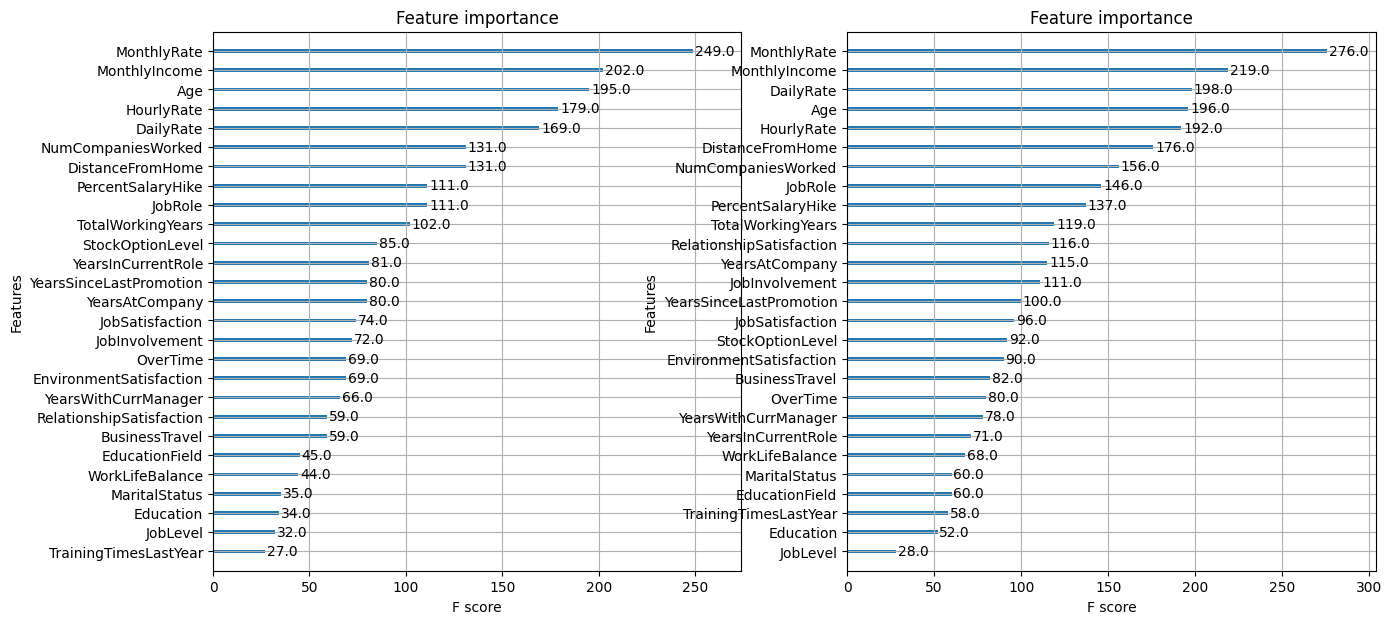

In [259]:
fig, ax = plt.subplots(1, 2, figsize=(15, 7))

xgb.plot_importance(model_param, ax=ax[0])
xgb.plot_importance(model_param_d, ax=ax[1])